In [214]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

from textblob.sentiments import NaiveBayesAnalyzer

import pandas as pd
import sqlite3
from textblob import TextBlob

import seaborn as sns
sns.set(color_codes=True)

# encoding=utf8
import sys
reload(sys)
sys.setdefaultencoding('utf8')

import spacy
nlp = spacy.load('en')

import re

## Load the dataframe in via CSV:

In [274]:
df = pd.read_csv('../pitchfork2.csv')

In [358]:
df_new = df[df['new_album'] == 1]
df_reissue = df[df['new_album'] == 0]

# What Are We Dealing With Here?

I ran a scraper on Jan 6, 2017 (credit to Nolan Conaway for creating the scraper -- I updated the scraper to accomodate changes to Pitchfork's html, and add columns for Best New Reissue and the Abstract), and captured 19,626 reviews dating back to 1999. The scrape includes the Artist, Album Name (title), Author, publication information, a bool column for each genre (some reviews have multiple listed), bools for Best New Music, Best New Reissue, and engineered features for whether it is a new release or a review of a previously released album. I also calculated a few sentiment scores, which will be explored later in the notebook.

In [185]:
df.info()

In [186]:
df_reissue[df_reissue['artist'] == 'brian eno']

,Unnamed: 0,index,reviewid,title,artist,url,score,best_new_music,best_new_reissue,author,...,content,abstract,reissue,num_years_since_release,new_album,abs_polarity,abs_subjectivity,cont_polarity,cont_subjectivity,score_bin
482,482,504,5978e0d551a4e60876242a99,here come the warm jets,brian eno,https://pitchfork.com/reviews/albums/brian-eno...,9.5,1,1,douglas wolk,...,Brian Eno s run of rock albums in the 70s was ...,Brian Eno s run of rock albums in the 70s was ...,1,43,0,0.300000,0.725000,0.137053,0.481034,9
1585,1585,1661,5929da7bd7a71d1ea5699be3,another green world,brian eno,https://pitchfork.com/reviews/albums/22061-ano...,10.0,0,0,mike powell,...,Brian Eno has done everything from producing h...,Brian Eno has done everything from producing h...,0,41,0,0.066667,0.566667,0.067955,0.429090,10
3678,3678,3861,5929e0e50c2bba1b7de029bd,nerve net,brian eno,https://pitchfork.com/reviews/albums/20032-bri...,7.7,0,0,douglas wolk,...,Brian Eno had a busy decade in the 1990s inclu...,Brian Eno had a busy decade in the 1990s inclu...,1,22,0,0.033333,0.150000,0.098761,0.382224,7
15142,15142,15739,5929e0fb0c2bba1b7de029dd,music for films,brian eno,https://pitchfork.com/reviews/albums/11732-mus...,7.8,0,0,mark pytlik,...,Latest batch of reissues from Brian Eno includ...,Latest batch of reissues from Brian Eno includ...,1,0,0,0.109091,0.563636,0.193928,0.505110,7
15726,15726,16351,5929e26feb335119a49eeffb,discreet music,brian eno,https://pitchfork.com/reviews/albums/11731-dis...,8.8,0,0,liam singer,...,Remember Teenage Fanclub s Bandwagonesque In 1...,NaN,0,29,0,0.000000,0.000000,0.142208,0.437625,8


In [187]:
df_reissue['best_new_reissue'].sum()

367L

Pitchfork increased the number of reviews published per year for its first few years. Since 2005, Pitchfork published ~1,200 reviews per year.

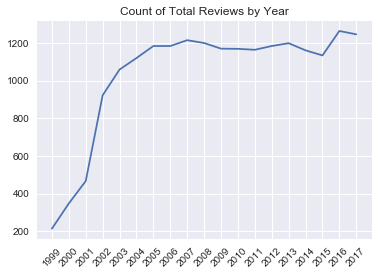

In [188]:
plt.title('Count of Total Reviews by Year')
plt.plot(df.groupby('pub_year').count()['reviewid'])
plt.xticks(range(1999,2018), rotation=45)
plt.show()

Pitchfork's "Best New Music" designation was introduced in 2003. Since 2009, Pitchfork labels between 80 and 100 albums as Best New Music.

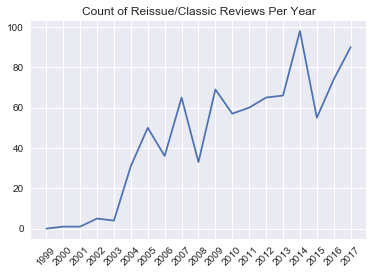

In [189]:
plt.plot(df.groupby('pub_year').sum()['reissue'])
plt.title("Count of Reissue/Classic Reviews Per Year")
plt.xticks(range(1999,2018), rotation=45)
plt.show()

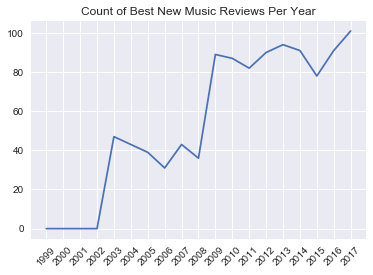

In [190]:
plt.plot(df.groupby('pub_year').sum()['best_new_music'])
plt.title("Count of Best New Music Reviews Per Year")
plt.xticks(range(1999,2018), rotation=45)
plt.show()

Best New Music albums usually receive a score of 8.3 or higher, though this is not a hard-and-fast rule.

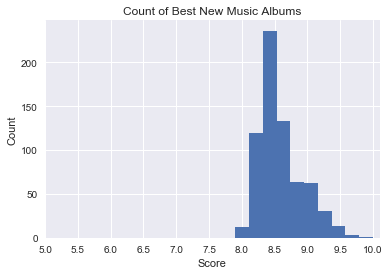

In [191]:
plt.hist(df_new[df_new['best_new_music'] == 1]['score'], bins=10)
plt.title('Count of Best New Music Albums')
plt.xticks(np.arange(5,10.5,.5))
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

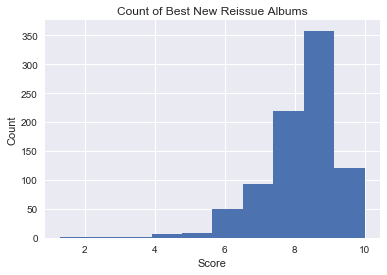

In [192]:
plt.hist(df[df['reissue'] == 1]['score'], bins=10)
plt.title('Count of Best New Reissue Albums')
# plt.xticks(np.arange(5,10.5,.5))
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# Distribution of Scores

The overall distribution of scores (for all albums on Pitchfork) is left skewed with a mean of 7.03. There is some expected selection bias, where Pitchfork generally reviews albums that are good enough for its readers to consume. Reviews with very low scores are either released by notable artists, or are written for entertainment value.

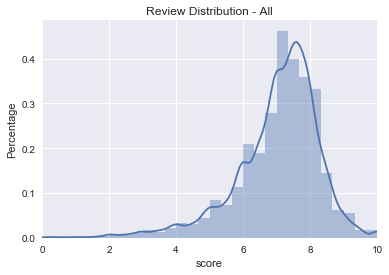

In [193]:
sns.distplot(df['score'], bins=30)
plt.title("Review Distribution - All")
plt.ylabel('Percentage')
plt.xlim(0,10)

plt.show()

print "Overall Mean:", df['score'].mean()

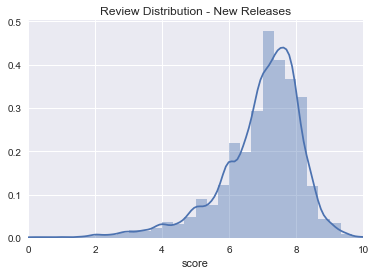

In [194]:
plt.title("Review Distribution - New Releases")
sns.distplot(df_new['score'], bins=30)
plt.xlim(0,10)

plt.show()

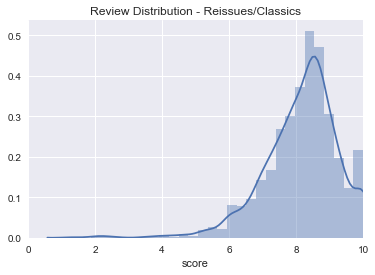

In [195]:
plt.title("Review Distribution - Reissues/Classics")
sns.distplot(df_reissue['score'], bins=30)
plt.xlim(0,10)
plt.show()

The yearly mean score hasn't changed much since 1999. Not much to see here.

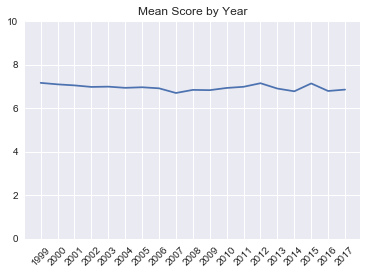

In [196]:
plt.plot(df_new['pub_year'].unique(), df_new.groupby('pub_year')['score'].mean())
plt.title('Mean Score by Year')
plt.ylim(0,10)
plt.xticks(range(1999, 2018), rotation=45)
plt.show()

## What's Happening in the Margins

In [197]:
years = np.arange(1999, 2018)
less3 = list(df_new[df_new['score'] <= 3].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
less6 = list(df_new[df_new['score'] <= 6].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
more9 = list(df_new[df_new['score'] >= 9].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
reis_more9 = list(df_reissue[df_reissue['score'] >= 9].groupby('pub_year').count()['reviewid'] / (df_reissue.groupby('pub_year')['reviewid'].count().astype(float)))

Pitchfork has sharply decreased its frequency of giving scathing reviews. Following are several visuals showing how Pitchfork has gotten more 'vanilla' over the years.

Pitchfork almost never gives out reviews below a 3, when previously it was pretty common. In 'the old days' of Pitchfork, reviews had an edge, where they felt targeting and malicious. Here's a link to a particularly scathing review of Liz Phair's album 'Liz Phair':

https://pitchfork.com/reviews/albums/6255-liz-phair/

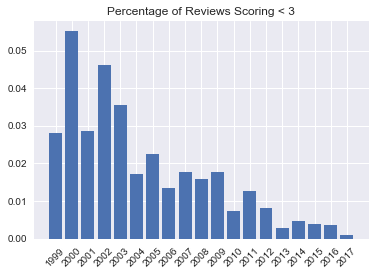

In [198]:
plt.bar(years, less3)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Reviews Scoring < 3")
plt.show()

It's becoming more rare to see albums scoring below a 6. Nearly 90% of reviews in 2017 were 6+. Pitchfork has all but abandoned giving negative reviews to albums. Taylor Swift, who previously had never been reviewed before, managed to score a 6.5 in 2017 -- just a few points lower than the critics average on metacritic.

http://www.metacritic.com/music/reputation/taylor-swift/critic-reviews

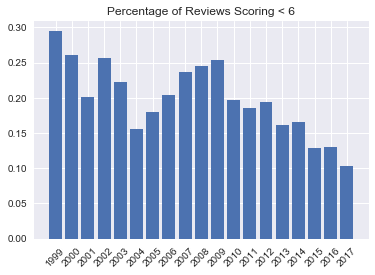

In [199]:
plt.bar(years, less6)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Reviews Scoring < 6")

plt.show()

Albums scoring above 9 are still a rare commodity. Since "Best New Music" launched in 2003, 9+ has been sacred space for Pitchfork reviews of new releases.

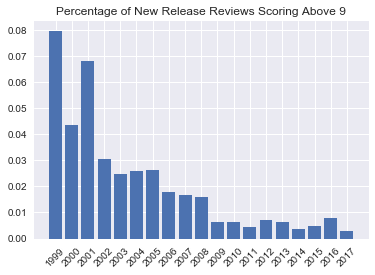

In [200]:
plt.bar(years, more9)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of New Release Reviews Scoring Above 9")

plt.show()

Classic albums and reissues are subject to hindsight scoring inflation. Not surprisingly, Pitchfork editors give 9+ reviews much more confidently to albums that have withstood the test of time.

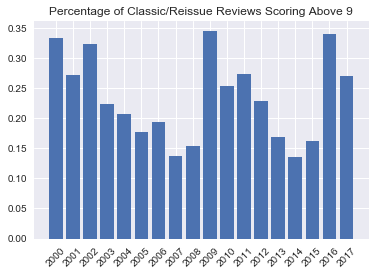

In [201]:
plt.bar(years[1:19], reis_more9)
plt.xticks(years[1:19], range(2000, 2018),rotation =45)
plt.title("Percentage of Classic/Reissue Reviews Scoring Above 9")

plt.show()

## The spread of scores is shrinking

With each major business launch, Pitchfork editors have narrowed the band of score they give throughout the year.

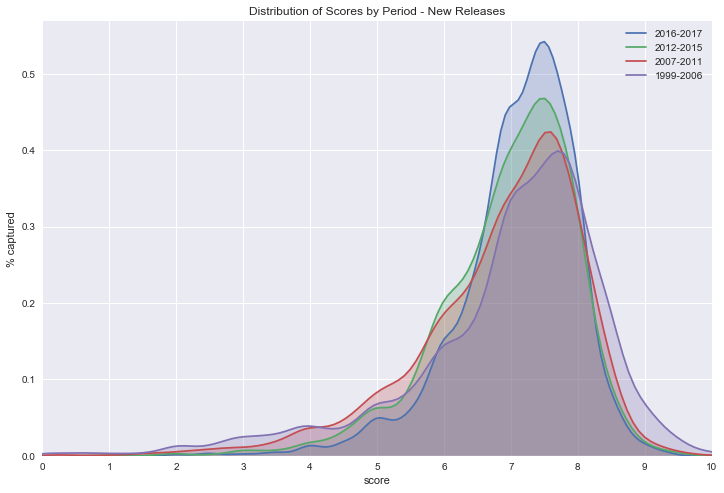

In [202]:
fig, ax = plt.subplots(figsize=(12,8))
plt.title('Distribution of Scores by Period - New Releases')
sns.kdeplot(df_new[(df_new['pub_year'] > 2014) & (df_new['pub_year'] < 2018)]['score'], shade=True, label='2016-2017')
sns.kdeplot(df_new[(df_new['pub_year'] > 2011) & (df_new['pub_year'] < 2015)]['score'], shade=True, label='2012-2015')
sns.kdeplot(df_new[(df_new['pub_year'] > 2007) & (df_new['pub_year'] < 2012)]['score'], shade=True, label='2007-2011')
sns.kdeplot(df_new[df_new['pub_year'] < 2007]['score'], shade=True, label='1999-2006')
plt.xlabel('score')
plt.xticks(range(0,11))
plt.xlim(0,10)
plt.ylabel('% captured')
plt.legend()
plt.show()

Since 1999, Pitchfork has always scored most of their albums between 6 and 9. But take a look at how the tails have shrunk over time.

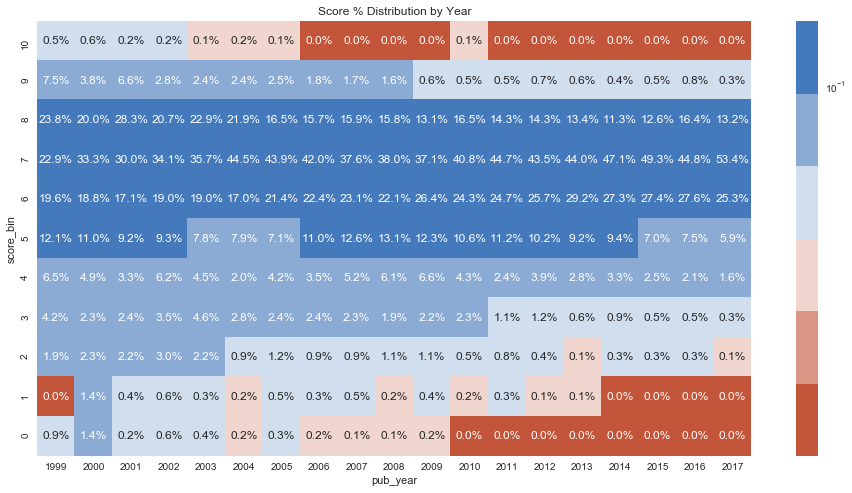

In [203]:
df_norm_col=(heatmap_df)/heatmap_df.sum()
temp_df = pd.DataFrame(df_new.groupby(['pub_year', 'score_bin'])['reviewid'].count()).reset_index()
heatmap_df = temp_df.pivot(index='score_bin', columns='pub_year', values='reviewid').fillna(0.01)

plt.figure(figsize=(16,8))
plt.title("Score % Distribution by Year")
plt.xlabel('Year')
plt.ylabel('Score')
sns.heatmap(df_norm_col[::-1], annot=(df_norm_col[::-1]).round(3), norm=LogNorm(vmin=0, vmax=1), 
            fmt='.1%', 
            cmap=sns.diverging_palette(20, 250, n=6))
plt.show()

In [204]:
# df_norm_col=(heatmap_df)/heatmap_df.sum()
# temp_df = pd.DataFrame(df_new.groupby(['pub_year', 'score_bin'])['reviewid'].count()).reset_index()
# heatmap_df = temp_df.pivot(index='score_bin', columns='pub_year', values='reviewid').fillna(0.01)

# plt.figure(figsize=(16,8))
# sns.heatmap(heatmap_df[::-1], annot=heatmap_df[::-1].round(1), norm=LogNorm(vmin=0, vmax=400), fmt='g', cmap=sns.diverging_palette(20, 250, n=6))

# plt.show()

Here's another way to look at it:

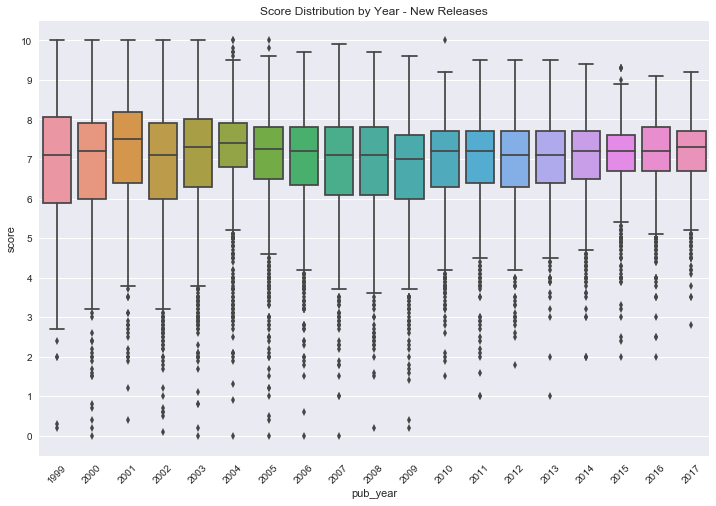

In [205]:
plt.figure(figsize=(12,8))

sns.boxplot(x=df_new['pub_year'], y=df_new['score'], data=df_new[['score', 'pub_year']])
plt.title('Score Distribution by Year - New Releases')
plt.yticks(np.arange(0,11))

plt.xticks(rotation=45)
plt.show()

In [206]:
# plt.figure(figsize=(12,8))
# sns.boxplot(x=df['pub_year'], y=df['score'], data=df[['score', 'pub_year']])
# plt.title('Score Distribution by Year')

# plt.yticks(np.arange(0,11))
# plt.xticks(rotation=45)
# plt.show()

In [207]:
# plt.figure(figsize=(12,8))

# sns.boxplot(x=df_reissue['pub_year'], y=df_reissue['score'], data=df_reissue[['score', 'pub_year']])
# plt.title("Score Distribution by Year -- Reissues and Classic Albums")
# plt.xticks(rotation=45)
# plt.yticks(np.arange(0,11))

# plt.show()

In [208]:
# score_by_year = df_new.groupby('pub_year').agg(['mean', 'max','min','count','sum']).reset_index()

# score_by_year['percent_bnm'] = score_by_year['best_new_music']['sum'] / score_by_year['score']['count']

# plt.plot(score_by_year['pub_year'][4:19], score_by_year['percent_bnm'][4:19])
# plt.title('Best New Music Frequency')
# plt.xticks(score_by_year['pub_year'][4:19], rotation=45)
# plt.yticks()
# plt.xlabel('Year')
# plt.ylabel('% of Albums Named Best New Music')
# plt.show()

# Basic NLP

I'm using TextBlob to measure the polarity and subjectivity of each review. Polarity is a score between [-1, 1] measuring positivity of text, and subjectivity is a score between [0, 1] where scores closer to 1 are more subjective. I ran the sentiment analysis of both the 1-2 sentence abstract preceding each review, as well as the entire review content.

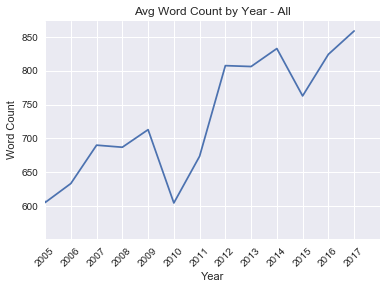

In [359]:
plt.plot(df['pub_year'].unique()[::-1], df.groupby('pub_year')['word_count'].mean())

plt.xticks(years, rotation=45)
plt.xlim(2005, 2018)
plt.xlabel('Year')
plt.ylabel('Word Count')
plt.title('Avg Word Count by Year - All')
plt.show()

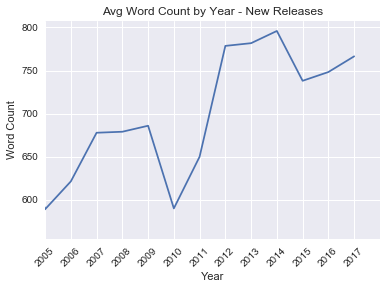

In [361]:
plt.plot(df_new['pub_year'].unique()[::-1], df_new.groupby('pub_year')['word_count'].mean())

plt.xticks(years, rotation=45)
plt.xlim(2005, 2018)
plt.xlabel('Year')
plt.ylabel('Word Count')
plt.title('Avg Word Count by Year - New Releases')
plt.show()

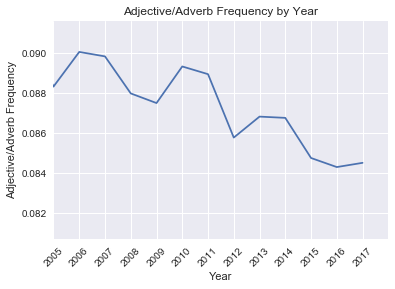

In [364]:
plt.plot(df_new['pub_year'].unique()[::-1], df_new.groupby('pub_year')['adj_freq'].mean())

plt.xticks(years, rotation=45)
plt.xlim(2005, 2018)
plt.xlabel('Year')
plt.ylabel('Adjective/Adverb Frequency')
plt.title('Adjective/Adverb Frequency by Year')
plt.show()

Average subjectivity of reviews has gone down year over year. Authors are becoming more objective, using language that is less opinion-based in the content. Yet, interestingly, the abstracts have gotten considerably *more* subjective in recent years. This makes sense -- readers can get a quick glance at Pitchfork's opinion, and then read more if they want to learn more about the album.

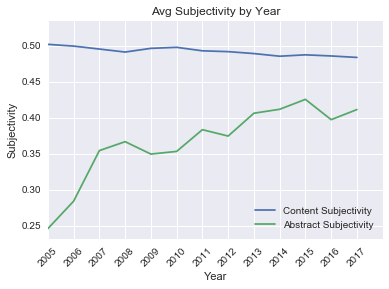

In [366]:
plt.plot(df['pub_year'].unique()[::-1], df.groupby('pub_year')['cont_subjectivity'].mean(), label='Content Subjectivity')
plt.plot(df['pub_year'].unique()[::-1], df.groupby('pub_year')['abs_subjectivity'].mean(), label='Abstract Subjectivity')

plt.xticks(years, rotation=45)
plt.xlim(2005, 2018)
plt.xlabel('Year')
plt.ylabel('Subjectivity')
plt.title('Avg Subjectivity by Year')
plt.legend()
plt.show()

Since negative and positive sentiments will average each other out, I'm filtering to look at Best New Music albums only when analysing polarity. In 2010 and 2014, editors were particularly enthusiastic in the abstract.

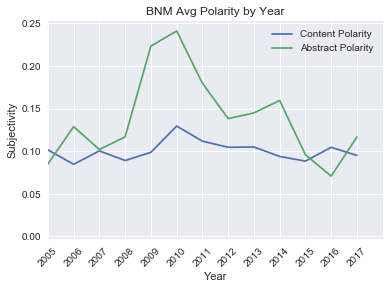

In [365]:
df_bnm = df_new[df_new['best_new_music'] == 1]

plt.plot(df_bnm['pub_year'].unique()[::-1], df_bnm.groupby('pub_year')['cont_polarity'].mean(), label='Content Polarity')
plt.plot(df_bnm['pub_year'].unique()[::-1], df_bnm.groupby('pub_year')['abs_polarity'].mean(), label='Abstract Polarity')

plt.xticks(years, rotation=45)
plt.xlim(2005, 2018)
plt.xlabel('Year')
plt.ylabel('Subjectivity')
plt.title('BNM Avg Polarity by Year')
plt.legend()
plt.show()

## Simple Linear Regression Using Subjectivity/Polarity

In [367]:
df_new[df_new['cont_polarity'] == -1]['non_PN_words']

Series([], Name: non_PN_words, dtype: object)

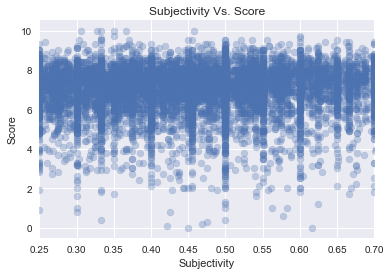

In [280]:
plt.scatter(df_new['abs_subjectivity'], df_new['score'], alpha=.3)
plt.title('Subjectivity Vs. Score')
plt.ylabel("Score")
plt.xlim(.25, .7)
plt.xlabel("Subjectivity")
plt.show()

In [282]:
df.head()

,Unnamed: 0,index,reviewid,title,artist,url,score,best_new_music,best_new_reissue,author,...,reissue,num_years_since_release,new_album,non_PN_words,content_adj,abs_polarity,abs_subjectivity,cont_polarity,cont_subjectivity,score_bin
0,0,22,5a3aa14cdea49a0a938ccb18,merry christmas lil mama: re-wrapped,"chance the rapper, jeremih",https://pitchfork.com/reviews/albums/merry-chr...,7.7,0,0,marc hogan,...,1,0,0,NaN,free brutal foreseeable beloved magnetic appro...,0.000000,0.000000,0.188451,0.565566,7
1,1,23,5a2eacf785030943c5158845,pressure,jeezy,https://pitchfork.com/reviews/albums/pressure/,6.3,0,0,sheldon pearce,...,0,0,1,effective new few,effective new few pusher recent high new socia...,0.178788,0.451515,0.059904,0.431901,6
2,2,24,5a0a0f9fd5ec0a321fb119a2,the beautiful & damned,g-eazy,https://pitchfork.com/reviews/albums/g-eazy-th...,5.1,0,0,sheldon pearce,...,0,0,1,new boozy minor key possible,new boozy minor key possible Beautiful sociali...,0.021591,0.663636,-0.097777,0.715553,5
3,3,25,5a285f957d91d040cf1e35e1,quiet storm,shy glizzy,https://pitchfork.com/reviews/albums/shy-glizz...,7.1,0,0,jay balfour,...,0,0,1,deft soft,deft soft unexpected jumpy eager obvious favor...,0.350000,0.625000,0.132828,0.510859,7
4,4,26,5a2eb9d5a31af72b3b598039,pop 2,charli xcx,https://pitchfork.com/reviews/albums/charli-xc...,8.4,1,0,meaghan garvey,...,0,0,1,eclectic romantic fun emotional,eclectic romantic fun emotional first robotic ...,0.100000,0.450000,0.099970,0.523161,8


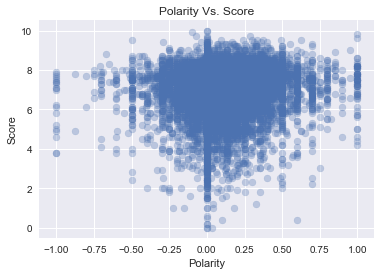

In [281]:
plt.scatter(df_new[df_new['pub_year'] > 2004]['abs_polarity'], df_new[df_new['pub_year'] > 2004]['score'], alpha=.3)
plt.title('Polarity Vs. Score')
plt.ylabel("Score")
plt.xlabel("Polarity")
plt.show()

In [133]:
import statsmodels.api as sm

In [134]:
Y = df['score']
X = df[['abs_polarity', 'cont_polarity', 'abs_subjectivity', 'cont_subjectivity', 'pub_year', 'new_album', 'genre_rock']]
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     278.3
Date:                Wed, 10 Jan 2018   Prob (F-statistic):               0.00
Time:                        09:02:52   Log-Likelihood:                -31701.
No. Observations:               19620   AIC:                         6.342e+04
Df Residuals:                   19612   BIC:                         6.348e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7474      3.746      0.200      0.842      -6.595       8.090
abs_polarity          0.0831      0.044      1.872      0.061      -0.004       0.170
cont_polarity         3.7056      0.166     22.323      0.000       3.380       4.031
abs_subjectivity      0.2191      0.039      5.572      0.000       0.142       0.296
cont_subjectivity    -0.9510      0.195     -4.865      0.000      -1.334      -0.568
pub_year              0.0037      0.002      1.977      0.048    3.11e-05       0.007
new_album            -1.1739      0.035    -33.643      0.000      -1.242      -1.106
genre_rock           -0.1383      0.018     -7.819      0.000      -0.173      -0.104
==============================================================================
Omnibus:                     4258.452   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10397.909
Skew:                          -1.204   Prob(JB):                         0.00
Kurtosis:                       5.632   Cond. No.                     8.66e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [137]:
def plot_subj_violins_score(df, genre='all genres'):
    scores = list(df.score_bin.unique())
    pol_dist = {1: [],}
    for pol,score in zip(df.subjectivity.astype(list), df.score_bin.astype(list)):
        if score not in pol_dist.keys():
            pol_dist[score] = []
        else:
            pol_dist[score] = pol_dist[score] + [pol]

    plt.figure(figsize=(30,14))
#     plt.hlines(df['subjectivity'].mean(), 0, 10, linestyles='dotted')
    for each in scores:
        plt.xticks(range(0,11), fontsize=16)
        plt.violinplot(np.array(pol_dist[each]), [each], widths=1,showmedians=True,showextrema=True)
    plt.title('Subjectivity Distribution by Score ({})'.format(genre), fontsize=24)
    plt.ylabel('Subjectivity', fontsize=16)
    plt.xlabel('Binned Score', fontsize=16)

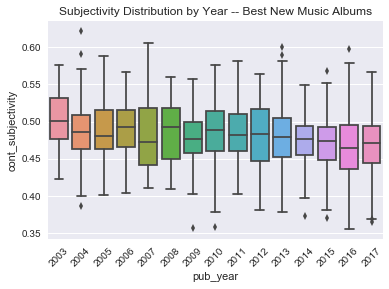

In [124]:
sns.boxplot(x=df[df['best_new_music'] == 1]['pub_year'], y=df[df['best_new_music'] == 1]['cont_subjectivity'], data=df[df['best_new_music'] == 1][['score', 'cont_subjectivity']])
# plt.ylim(.28, .7)
plt.title("Subjectivity Distribution by Year -- Best New Music Albums")
plt.xticks(rotation=45)
# plt.yticks(np.arange(.3,.7,.025))

plt.show()

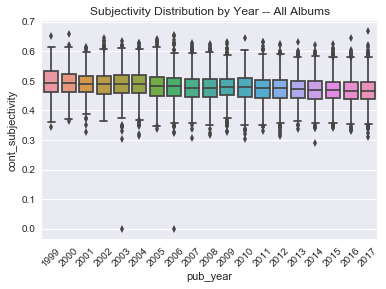

In [127]:
sns.boxplot(x=df['pub_year'], y=df['cont_subjectivity'], data=df[['score', 'cont_subjectivity']])
# plt.ylim(.28, .7)
plt.title("Subjectivity Distribution by Year -- All Albums")
# plt.yticks(np.arange(.3,.7,.025))

plt.xticks(rotation=45)
plt.show()

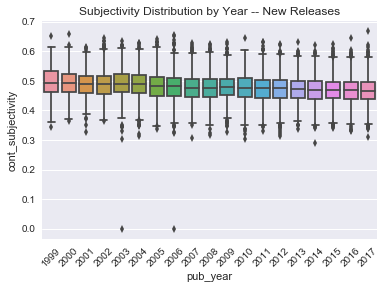

In [129]:
sns.boxplot(x=df_new['pub_year'], y=df_new['cont_subjectivity'], data=df_new[['score', 'cont_subjectivity']])
plt.title("Subjectivity Distribution by Year -- New Releases")
# plt.ylim(.28, .7)
plt.xticks(rotation=45)
# plt.yticks(np.arange(.3,.7,.025))

plt.show()

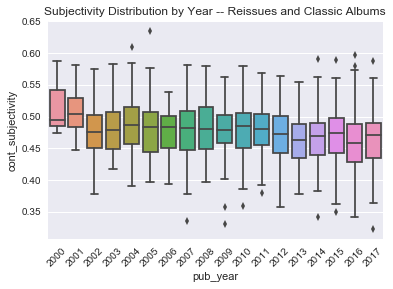

In [130]:
sns.boxplot(x=df_reissue['pub_year'], y=df_reissue['cont_subjectivity'], data=df_reissue[['score', 'cont_subjectivity']])
plt.title("Subjectivity Distribution by Year -- Reissues and Classic Albums")
plt.xticks(rotation=45)
# plt.yticks(np.arange(.3,.7,.025))

plt.show()